In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import cloudpickle as pickle
import os
from tqdm.auto import tqdm
import pandas as pd
from causal_util.helpers import CPU_Unpickler
from encoder.digit_encoder import digit_to_np
import seaborn as sns
from matplotlib import pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

# Analyzing the fitted model
- The graph is sparse
- Reconstruction loss is low
- Features are a bit more correlated with the digits!

In [4]:
trial_name = 'main_fcn_7f8cb_00000_0_2021-03-24_21-21-21'
config_name = 'rl_const_sparsity_obs_space_env_ve5_with_rew_done_with_lagrange_dual_sparsity'
ckpt = f'/home/sergei/ray_results/{config_name}/{trial_name}/checkpoint_66108/checkpoint'

In [5]:
l = CPU_Unpickler(open(ckpt, 'rb')).load()

Selecting name fca6de28-8dd5-11eb-81af-90e2baa15164


2021-03-26 02:52:57,790	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8269


Make environment VectorIncrement-v0 None {}
(pid=20685) Make environment VectorIncrement-v0 None {}
(pid=20686) Make environment VectorIncrement-v0 None {}
(pid=20684) Make environment VectorIncrement-v0 None {}
(pid=20704) Make environment VectorIncrement-v0 None {}
(pid=20669) Make environment VectorIncrement-v0 None {}


  0.73449737 0.72703725 0.42831427 0.         0.36525366 0.697887
  0.66378665 0.68829685 0.43334433 0.4294043  0.43351433 0.26224262
  0.6848968 ]
 [0.26223263 0.         0.42143422 0.         0.         0.700987
  0.         0.72950727 0.         0.400074   0.53450537 0.6771468
  0.         0.66637665 0.43334433 0.26501265 0.398884   0.43351433
  0.3581136 ]
 [0.         0.         0.         0.40540406 0.40583405 0.67117673
  0.69516695 0.51625514 0.67100674 0.2704927  0.         0.6682167
  0.73245734 0.42831427 0.67466676 0.4294043  0.2704927  0.26681268
  0.        ]
 [0.7331873  0.43351433 0.7307473  0.697427   0.73275733 0.
  0.7355174  0.5217152  0.51438516 0.66561663 0.5289353  0.
  0.26550266 0.7377674  0.36711368 0.52318525 0.26501265 0.66875666
  0.53259534]
 [0.52442527 0.36368364 0.699577   0.70318705 0.6732267  0.7349874
  0.70336705 0.42143422 0.398304   0.         0.26681268 0.42831427
  0.4294043  0.26550266 0.         0.5292453  0.43334433 0.36597365
  0.69612694]] 

ERROR:root:Cannot collect data Use collect_and_get_context



[False, False, False]
[22, 256, 256, 1] 8
[False, False]
[95, 128, 1] 5
[False, False, False]
[6, 256, 128, 1] 95


LSD (OrderedDict([('tensor', tensor([ 2.1379, -0.0284, -0.6699, -1.7930,  6.7890,  5.8895,  6.3148,  3.6906,
        -8.8224, -5.4761, -9.5608, -7.4610,  0.0000])), ('initialized', [True, True, True, True, True, True, True, True, True, True, True, True, False])]),) {'strict': False}


In [6]:
ctx = l.collect_and_get_context()

In [14]:
l.config.get('losses')['primal']['fcn'](**ctx)

{'loss': tensor(8.1596, grad_fn=<AddBackward0>),
 'metrics': {'fit': {'value': -45.42562484741211,
   'coeff': 1.0,
   'mean_feature': array([ 1.2855592e+00, -1.4598843e+00, -1.8276738e+00,  8.1409144e-01,
          -1.1095059e+00, -4.4345857e-08], dtype=float32),
   'std_feature': array([1.402766 , 1.9855176, 2.5865853, 1.9689978, 1.4827119, 0.5782171],
         dtype=float32),
   'min_feature': -5.798358917236328,
   'max_feature': 4.820840835571289,
   'loss_fcons': 0.01824224926531315,
   'loss_add': 0.011206299066543579,
   'loss_rec': 0.1847369521856308,
   'loss_fcons_pre': 0.01902219094336033,
   'rec_fit_acc_loss_01_agg': 1.0004315972328186,
   'loss_discrete': -45.65883255004883,
   'loss_orig': 0.23320770263671875},
  'fit/additional': {'value': -0.20601767301559448},
  'fit/obs': {'value': -45.42562484741211},
  'fit/feat': {'value': -0.7993269562721252},
  'fit/feat_model': {'value': -0.8389340043067932},
  'fit/additional_orig': {'value': 0.011206299066543579, 'coeff': 1.

In [7]:
l.config.get('losses')['fit']['fcn'](**ctx, loss_local_cache={})

KeyError: 'fit'

In [15]:
def unperm(obs):
    unperm = np.argsort(l.env.env.perm)
    return obs.flatten()[unperm].reshape(obs.shape)

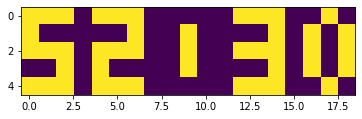

In [16]:
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[0].detach().cpu().numpy()))

In [17]:
fx = l.decoder(ctx['obs_x'])

In [18]:
fnext_model = l.model(l.rot_pre(fx), ctx['action_x'], all=True)
fnext = l.rot_post(fnext_model[:, :l.feature_shape[0] + 1])

In [19]:
obs_rec = l.reconstructor(fnext)
obs_rec_denorm = l.normalizers['obs'].unnormalize(obs_rec.detach().numpy())

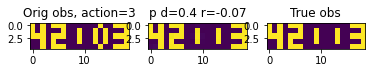

In [20]:
idx = np.random.choice(len(fx))
rew = round(l.normalizers['rew_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][0].item()]))[0], 2)
done = round(l.normalizers['done_y'].unnormalize(
    np.array([fnext_model[idx, l.feature_shape[0]:][1].item()]))[0], 2)
plt.subplot(1, 3, 1)
plt.title(f'Orig obs, action={np.argmax(ctx["action_x"][idx].numpy())}')
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_x'])[idx].detach().cpu().numpy()))
plt.subplot(1, 3, 2)
plt.title(f"p d={done} r={rew}")
plt.imshow(unperm(obs_rec_denorm[idx]))
plt.subplot(1, 3, 3)
plt.title("True obs")
plt.imshow(unperm(l.normalizers['obs'].unnormalize(ctx['obs_y'])[idx].detach().cpu().numpy()))

In [21]:
rew_true = ctx['rew_y'].flatten().numpy()
rew_pred = fnext_model[:, l.feature_shape[0]:][:, 0].flatten().detach().numpy()

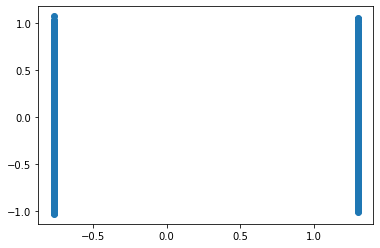

In [22]:
plt.scatter(rew_true, rew_pred)

In [23]:
done_true = ctx['done_y'].flatten().numpy()
done_pred = fnext_model[:, l.feature_shape[0]:][:, 1].flatten().detach().numpy()

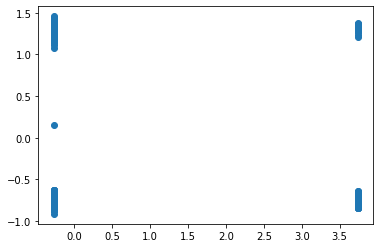

In [24]:
plt.scatter(done_true, done_pred)

In [25]:
obs_x_unnorm = l.normalizers['obs'].unnormalize(ctx['obs_x']).detach().cpu().numpy()

In [26]:
digits = [1. * digit_to_np(z) for z in range(22)]

In [27]:
obs = unperm(obs_x_unnorm[0])

In [28]:
def obs_to_digits(obs_unperm):
    offset = 0
    r = []
    while offset + 3 <= obs_unperm.shape[1]:
        r.append(obs_unperm[:, offset:offset+3])
        offset += 4
    return r

In [29]:
ds = obs_to_digits(obs)

In [30]:
def decode_digit(d_given):
    return np.argmin([np.abs(d_given - digit).mean() for digit in digits])
ds = [decode_digit(d) for d in ds]

[5, 2, 1, 3, 0]


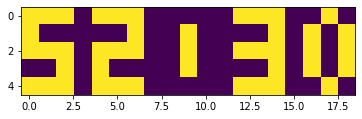

In [31]:
print(ds)
plt.imshow(obs)

In [32]:
def get_f(obs_unnorm):
    obs = unperm(obs_unnorm)
    ds = obs_to_digits(obs)
    ds = [decode_digit(d) for d in ds]
    return ds

In [33]:
features = np.array([get_f(obs) for obs in obs_x_unnorm])

[1 3 0 4 1]


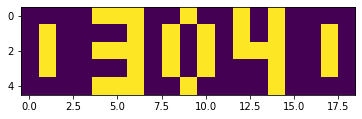

In [34]:
print(features[123])
plt.imshow(unperm(obs_x_unnorm[123]))

In [35]:
f_pred = l.decoder(ctx['obs_x']).detach().cpu().numpy()

In [36]:
df_pred = pd.DataFrame(f_pred, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
df_true = pd.DataFrame(features, columns=['d1', 'd2', 'd3', 'd4', 'd5'])

In [37]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2'] + df_all['d3'] + df_all['d4'] + df_all['d5']

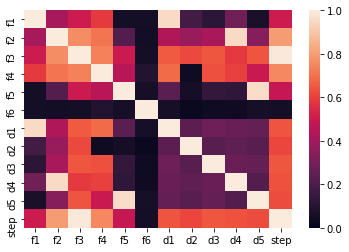

In [39]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)
plt.savefig('../../ve5_feature_corr.pdf', bbox_inches='tight')

In [42]:
!pip install statsmodels patsy

     |################################| 9.5 MB 4.6 MB/s eta 0:00:01
     |################################| 231 kB 41.1 MB/s eta 0:00:01


In [43]:
import statsmodels.api as sm
from patsy import dmatrices

In [61]:
y, X = dmatrices('d1 ~ f1 + f2 + f3 + f4 + f5', data=df_all, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     d1   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     9855.
Date:                Fri, 26 Mar 2021   Prob (F-statistic):               0.00
Time:                        03:04:11   Log-Likelihood:                 255.67
No. Observations:                1000   AIC:                            -499.3
Df Residuals:                     994   BIC:                            -469.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5139      0.011    225.928      0.000       2.492       2.536
f1            -0.8957      0.006   -142.730      0.000      -0.908      -0.883
f2            -0.0155      0.005     -3.080      0.002      -0.025      -0.006
f3             0.0265      0.005      5.875      0.000       0.018       0.035
f4            -0.0175      0.006     -3.084      0.002      -0.029      -0.006
f5            -0.0051      0.004     -1.314      0.189      -0.013       0.003
==============================================================================
Omnibus:                      557.364   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7812.273
Skew:                           2.247   Prob(JB):                         0.00
Kurtosis:                      15.935   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

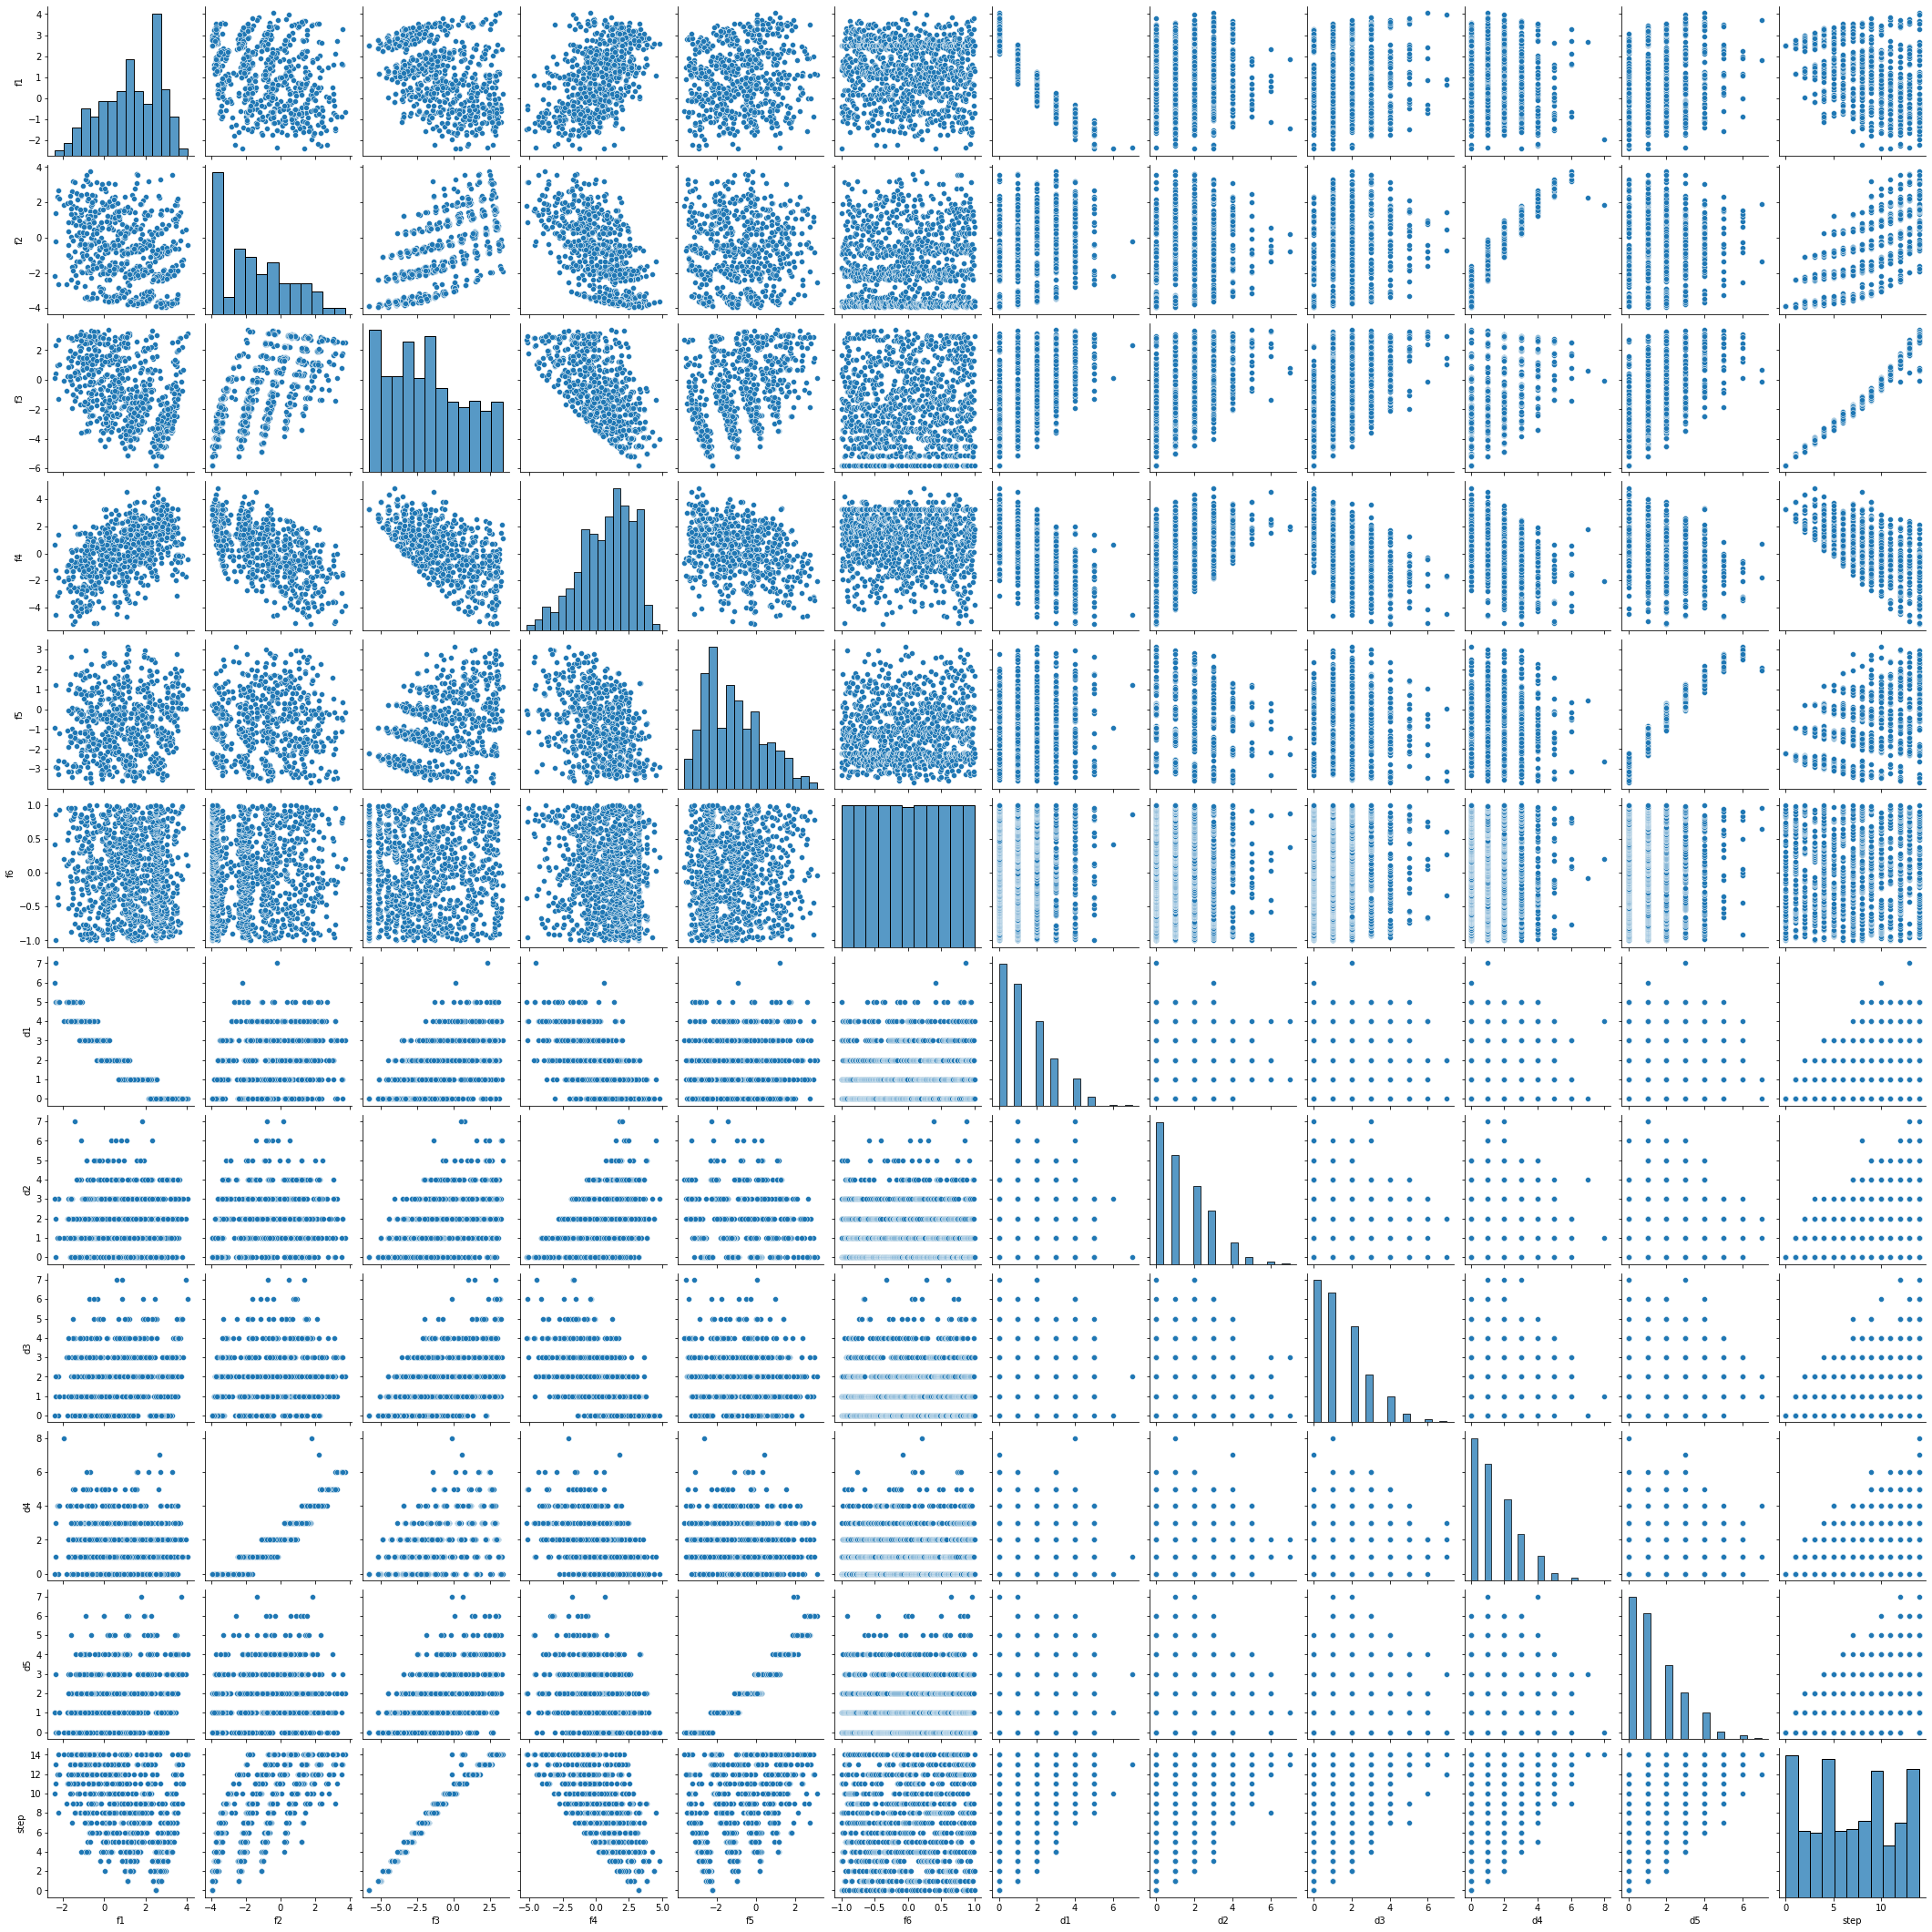

In [45]:
sns.pairplot(df_all)

In [46]:
import tensorflow as tf

In [47]:
m = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_shape=(6,), activation='tanh'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(5, activation=None)
])
m.compile('adam', 'mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [48]:
h = m.fit(np.array(df_pred), np.array(df_true), epochs=2000, verbose=0)

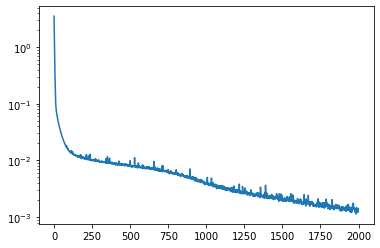

In [49]:
plt.plot(h.history['loss'])
plt.yscale('log')

In [70]:
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices, plot_model

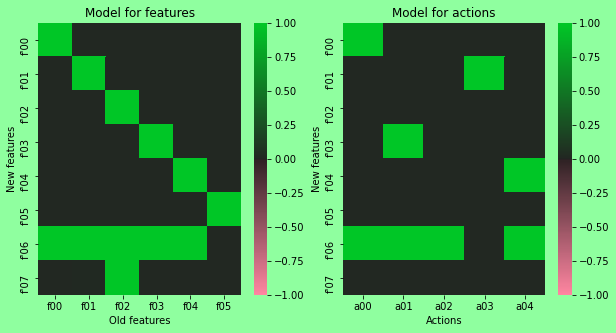

In [73]:
fig = plot_model(l.model)
fig.savefig('ve5_learned_graph_matrix.pdf', bbox_inches='tight')

In [82]:
res_json = f'/home/sergei/ray_results/{config_name}/{trial_name}/'

In [83]:
from causal_analysis.helpers import get_df_from_logdir

In [85]:
df = get_df_from_logdir(res_json)

In [87]:
list(df.columns)

['epochs',
 'n_samples',
 'losses/opt1d/primal/coeff',
 'losses/opt1d/primal/value',
 'losses/opt1d/value',
 'losses/opt2/dual/coeff',
 'losses/opt2/dual/value',
 'losses/opt2/value',
 'grads/opt1d/grad_total_l1mean',
 'grads/opt1d/grad_total_l2sum',
 'grads/opt2/grad_total_l1mean',
 'grads/opt2/grad_total_l2sum',
 'metrics/batch_index',
 'metrics/batch_size',
 'metrics/primal/fit/value',
 'metrics/primal/fit/coeff',
 'metrics/primal/fit/mean_feature',
 'metrics/primal/fit/std_feature',
 'metrics/primal/fit/min_feature',
 'metrics/primal/fit/max_feature',
 'metrics/primal/fit/loss_fcons',
 'metrics/primal/fit/loss_add',
 'metrics/primal/fit/loss_rec',
 'metrics/primal/fit/loss_fcons_pre',
 'metrics/primal/fit/rec_fit_acc_loss_01_agg',
 'metrics/primal/fit/loss_discrete',
 'metrics/primal/fit/loss_orig',
 'metrics/primal/fit/additional/value',
 'metrics/primal/fit/obs/value',
 'metrics/primal/fit/feat/value',
 'metrics/primal/fit/feat_model/value',
 'metrics/primal/fit/additional_orig/v

In [89]:
df['hours'] = df['time_since_restore'] / 3600

In [93]:
df['metrics/dual/lagrange_multiplier_fit/obs'].isnull()

0        False
1         True
2         True
3         True
4         True
         ...  
66103     True
66104     True
66105    False
66106     True
66107     True
Name: metrics/dual/lagrange_multiplier_fit/obs, Length: 66108, dtype: bool

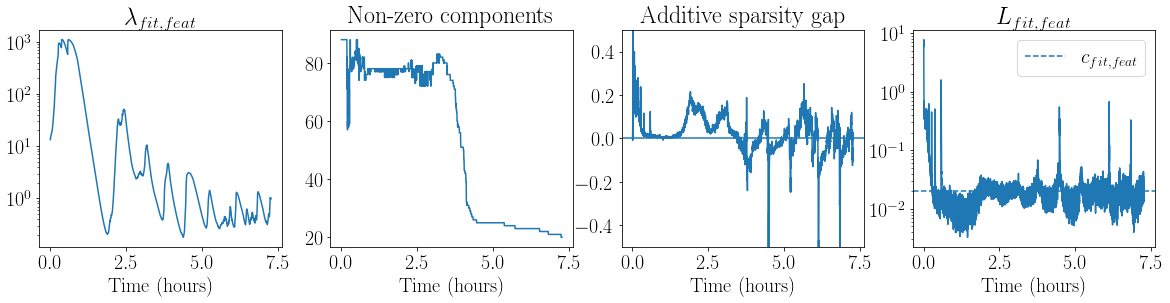

In [111]:
def plot_y(key):
    y = df[key]
    x = df['hours']
    
    x = x[~y.isnull()]
    y = y[~y.isnull()]
    plt.plot(x, y)
    plt.xlabel('Time (hours)')
    
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title('$\lambda_{fit,feat}$')
plot_y('metrics/dual/lagrange_multiplier_fit/feat')
plt.yscale('log')
plt.subplot(1, 4, 2)
plt.title('Non-zero components')
plot_y('metrics/nnz')
plt.subplot(1, 4, 3)
plt.title('Additive sparsity gap')
plot_y('metrics/|last_add_sparsity_gap')
plt.axhline(0)
plt.ylim((-0.5, 0.5))

plt.subplot(1, 4, 4)
plt.title('$L_{fit,feat}$')
plt.yscale('log')
plt.axhline(0.02, ls='--', label='$c_{fit,feat}$')
plt.legend()
plot_y('metrics/dual/fit/feat_orig/value')

plt.savefig('ve5_train_losses.pdf', bbox_inches='tight')

In [96]:
plt.rcParams.update({
    #'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family' : 'normal',
        'font.weight' : 'normal',
        'font.size'   : 20
})


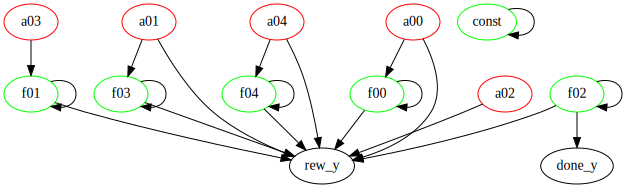

In [69]:
g = graph_for_matrices(l.model, last_is_constant=True)[0]
g.view()
g

In [50]:
# The model learns a pretty much random values for the features...
# trying post-features

In [51]:
f_pred_post = l.rot_pre(l.decoder(ctx['obs_x'])).detach().cpu().numpy()

In [52]:
df_pred = pd.DataFrame(f_pred_post, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
df_true = pd.DataFrame(features, columns=['d1', 'd2', 'd3', 'd4', 'd5'])

In [53]:
df_all = pd.concat([df_pred, df_true], axis=1)
df_all['step'] = df_all['d1'] + df_all['d2'] + df_all['d3'] + df_all['d4'] + df_all['d5']

<AxesSubplot:>

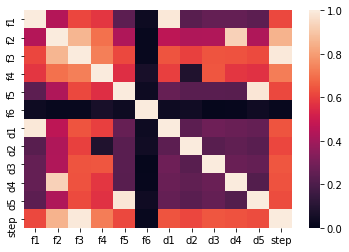

In [54]:
sns.heatmap(np.abs(df_all.corr()), vmin=0, vmax=1)

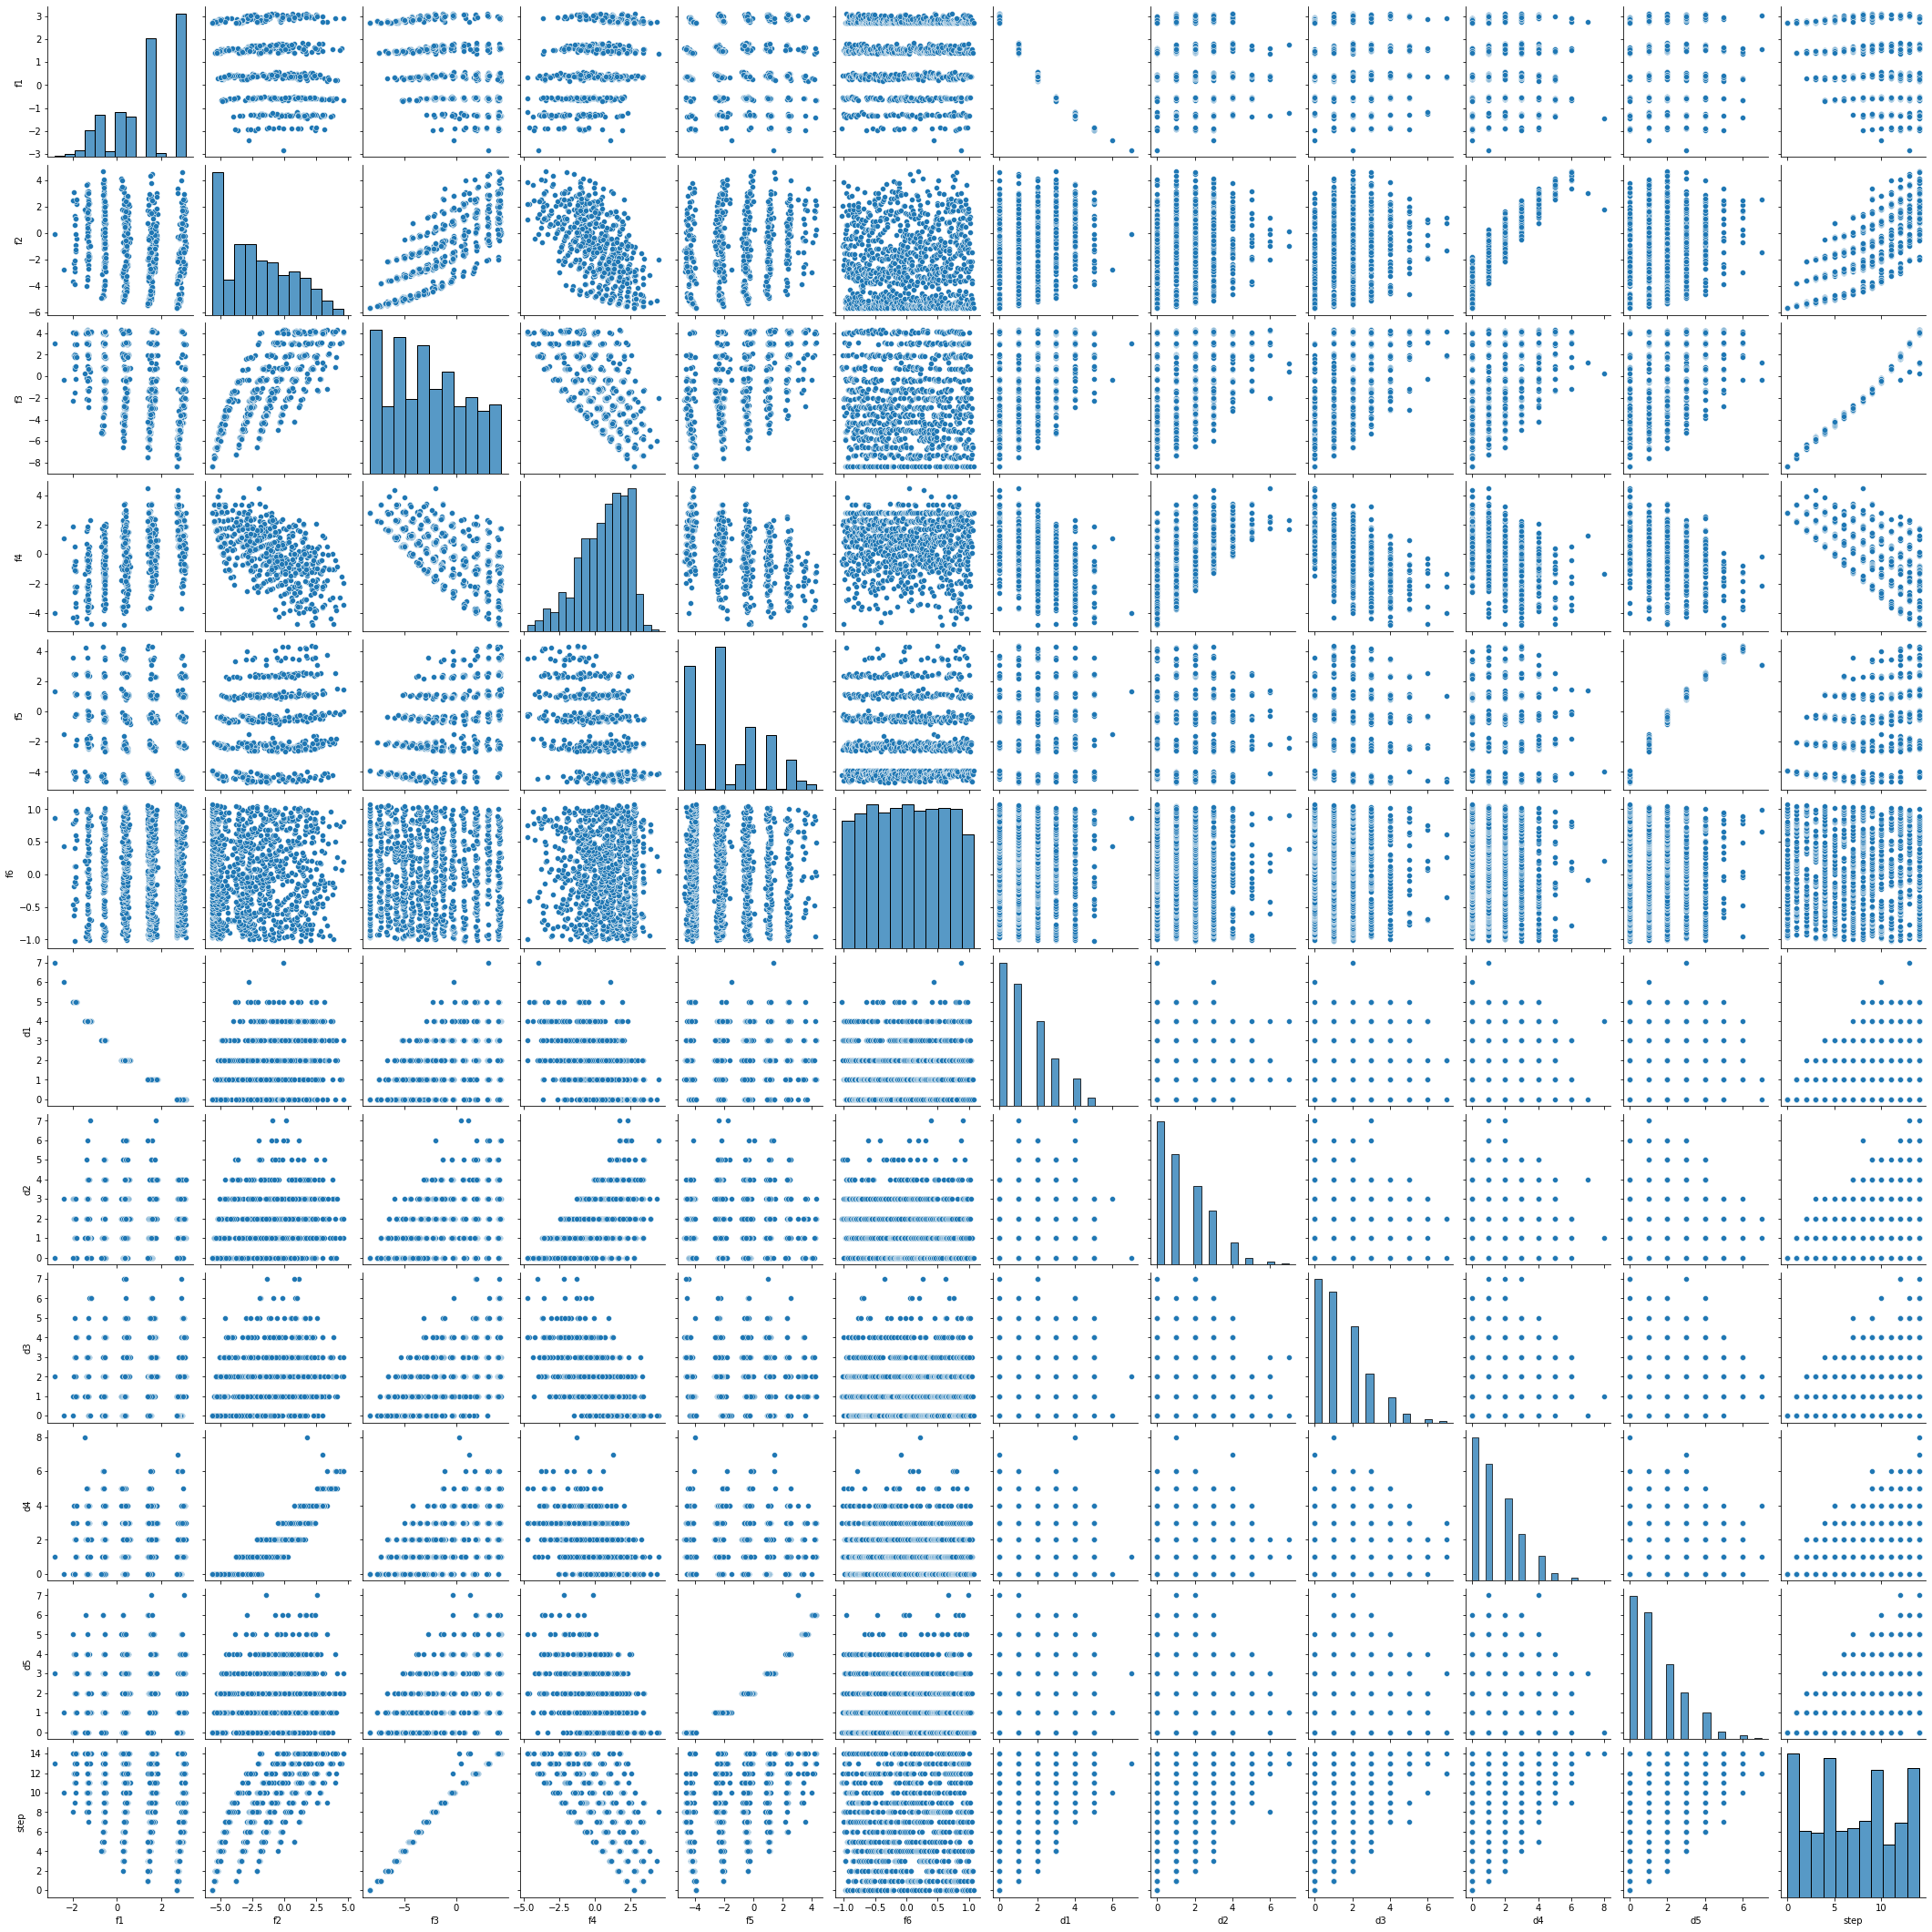

In [55]:
sns.pairplot(df_all)

# Creating an animated graph gif...

In [108]:
from plot_gif_model import gifify_trial_images, display_image, plot_hist_values, get_trial_by_epochs

In [109]:
results = f'/home/sergei/ray_results/{config_name}/{trial_name}/result.json'

In [110]:
trial_by_epochs = get_trial_by_epochs(results)

In [111]:
display_image(gifify_trial_images(trial_by_epochs, 'CausalModel.png'))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/CausalModel.png_all.gif

In [112]:
display_image(gifify_trial_images(trial_by_epochs, 'model.png'))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/model.png_all.gif

In [26]:
trial_by_epochs[0]

{'epochs': 0,
 'n_samples': 1000,
 'losses/opt1/fit/coeff': 0.14,
 'losses/opt1/fit/value': 262.5650939941406,
 'losses/opt1/sparsity/coeff': 0.02,
 'losses/opt1/sparsity/value': 58.29999923706055,
 'losses/opt1/fit_all_on/coeff': 0.05,
 'losses/opt1/fit_all_on/value': 382.5262756347656,
 'losses/opt1/reconstruction/coeff': 0.01,
 'losses/opt1/reconstruction/value': 77.40986633300781,
 'losses/opt1/fit_all_half/coeff': 0.01,
 'losses/opt1/fit_all_half/value': 253.43942260742188,
 'losses/opt1/value': 60.359920501708984,
 'grads/opt1/grad_total_l1mean': 3.060454137280407,
 'grads/opt1/grad_total_l2sum': 926.9329749668159,
 'metrics/batch_index': 0,
 'metrics/batch_size': -1,
 'metrics/fit/mean_feature': '[ 0.03433687  0.12825611 -0.04708277  0.10400862 -0.06344575  0.04275775]',
 'metrics/fit/std_feature': '[0.06169575 0.08960629 0.05721147 0.06226677 0.08051208 0.06895346]',
 'metrics/fit/min_feature': -0.23282650113105774,
 'metrics/fit/max_feature': 0.3464719355106354,
 'metrics/fit/

In [27]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'losses/opt1/sparsity/value')))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/lossesopt1sparsityvalue.png_all.gif

In [28]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/|last_mult_sparsity_gap', log=True)))

/home/sergei/causality-disentanglement-rl/causal_analysis/plot_gif_model.py:156: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricslastmultsparsitygap.png_all.gif

In [29]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/nnz', log=False)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsnnz.png_all.gif

In [30]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'losses/opt1/fit/value', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/lossesopt1fitvalue.png_all.gif

In [31]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/rec_fit_acc_loss_01_agg', log=False)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitrecfitaccloss01agg.png_all.gif

In [32]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/loss_fcons', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitlossfcons.png_all.gif

In [33]:
display_image(gifify_trial_images(trial_by_epochs,
                                  plot_hist_values(trial_by_epochs, 'metrics/fit/loss_rec', log=True)))

/home/sergei/causality-disentanglement-rl/results/rl_const_sparsity_obs_space_env_ve5_with_rew_done/metricsfitlossrec.png_all.gif

# Showing which weights change

In [84]:
import gin
import sparse_causal_model_learner_rl.config
from causal_util.helpers import lstdct2dctlst
gin.enter_interactive_mode()

In [40]:
gin.bind_parameter('Config._unpickle_skip_init', True)

In [43]:
checkpoints_by_epochs = {epoch: trial.get('checkpoint_tune', None) for epoch, trial in trial_by_epochs.items()}
checkpoints_by_epochs = {x: y for x, y in checkpoints_by_epochs.items() if y is not None}

In [54]:
epochs = sorted(checkpoints_by_epochs.keys())
ckpts = [checkpoints_by_epochs[e] for e in epochs]

In [55]:
weights_by_epochs = [
    CPU_Unpickler(open(ckpt, 'rb')).load()._unpickled_state['trainables_weights']
    for ckpt in tqdm(ckpts)
]

In [89]:
def flat_weights_dict(w):
    """{model: {w: val}} -> {model/w -> val}."""
    w_flat = {}
    endswith_blacklist = ['num_batches_tracked', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var']
    for trainable, t_weights in w.items():
        for w_name, w_value in t_weights.items():
            if any([w_name.endswith(t) for t in endswith_blacklist]):
                continue
            w_flat[f'{trainable}/{w_name}'] = w_value
    return w_flat

In [90]:
ws_flat = [flat_weights_dict(w) for w in weights_by_epochs]
wkeys = sorted(ws_flat[0].keys())

In [96]:
prev = ws_flat[0]
ws_flat_delta = []

for item in tqdm(ws_flat):
    ws_flat_delta_item = {}
    for wkey in wkeys:
        prev_item = prev[wkey]
        curr_item = item[wkey]
        scale = prev_item.abs()
        scale = torch.where(scale < 1e-8, torch.ones_like(scale), scale)
        delta = ((prev_item - curr_item) / scale).abs().mean().item()
        ws_flat_delta_item[wkey] = delta
    ws_flat_delta.append(ws_flat_delta_item)
    prev = item

In [97]:
deltas_dct = lstdct2dctlst(ws_flat_delta)

In [100]:
deltas_dct.keys()

dict_keys(['decoder/model.fc01.bias', 'decoder/model.fc01.weight', 'decoder/model.fc02.bias', 'decoder/model.fc02.weight', 'decoder/model.fc03.bias', 'decoder/model.fc03.weight', 'decoder/model.fc04.bias', 'decoder/model.fc04.weight', 'decoder/model.fc05.bias', 'decoder/model.fc05.weight', 'model/model.model.fc01.bias', 'model/model.model.fc01.weight', 'model/model.model.fc02.bias', 'model/model.model.fc02.weight', 'model/model.model.fc03.bias', 'model/model.model.fc03.weight', 'model/model.model.fc04.bias', 'model/model.model.fc04.weight', 'model/model.switch.probas', 'reconstructor/model.fc01.bias', 'reconstructor/model.fc01.weight', 'reconstructor/model.fc02.bias', 'reconstructor/model.fc02.weight', 'reconstructor/model.fc03.bias', 'reconstructor/model.fc03.weight', 'reconstructor/model.fc04.bias', 'reconstructor/model.fc04.weight', 'reconstructor/model.fc05.bias', 'reconstructor/model.fc05.weight', 'rot_post/rot.bias', 'rot_post/rot.weight', 'rot_pre/rot.bias', 'rot_pre/rot.weight'

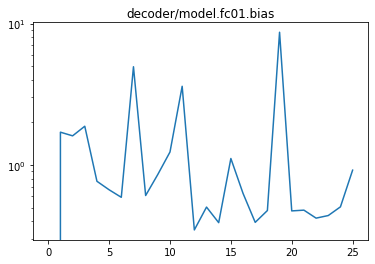

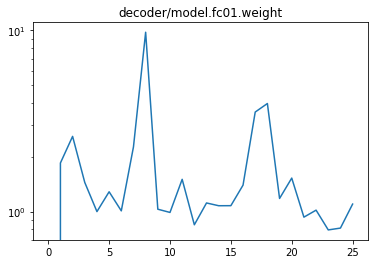

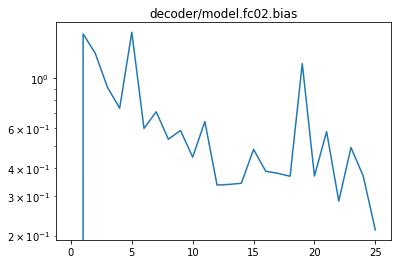

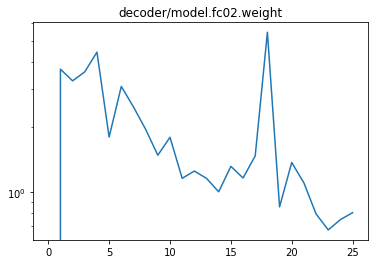

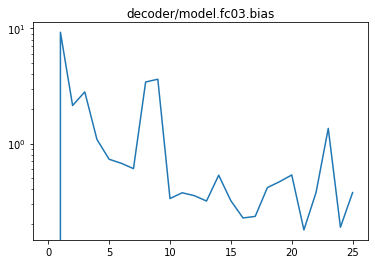

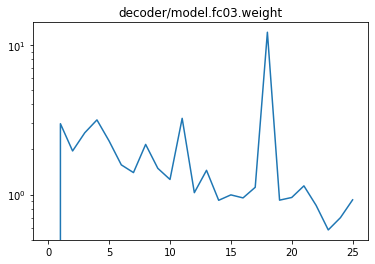

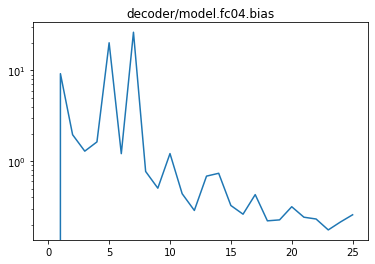

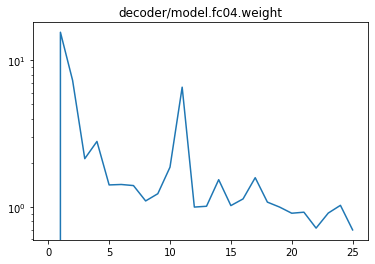

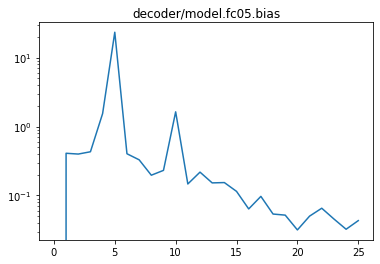

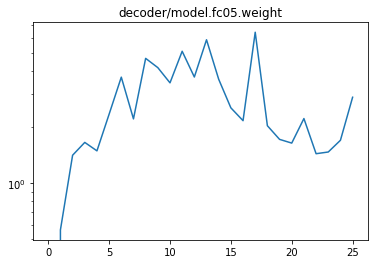

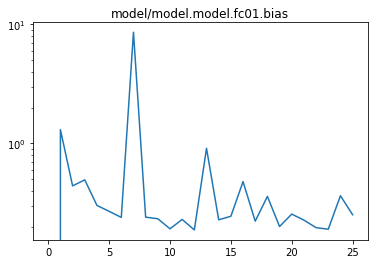

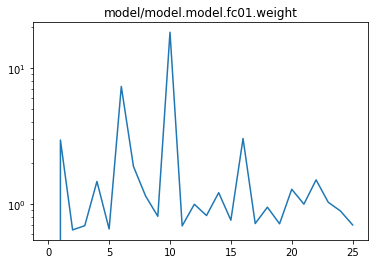

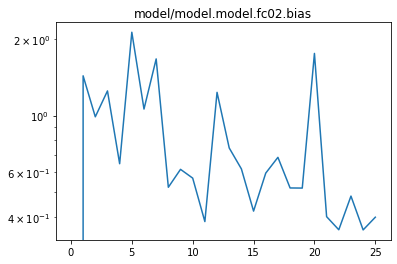

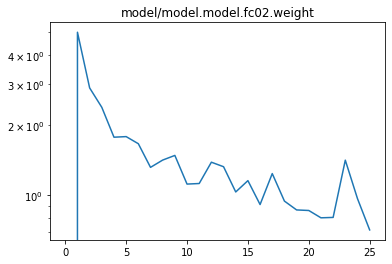

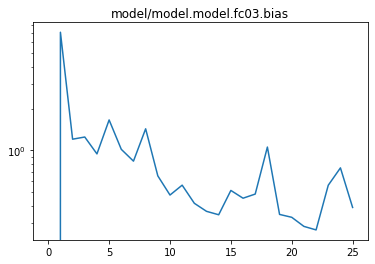

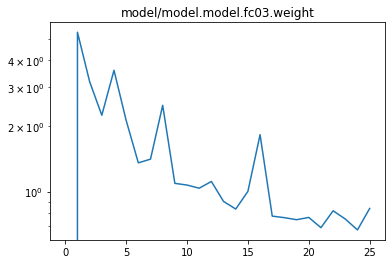

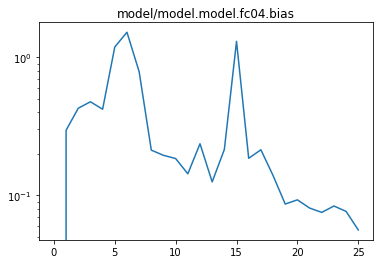

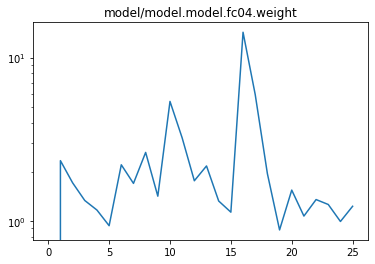

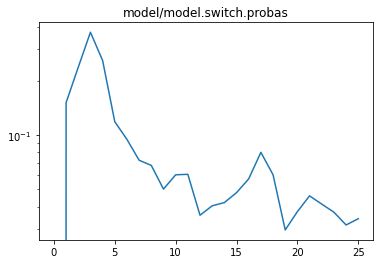

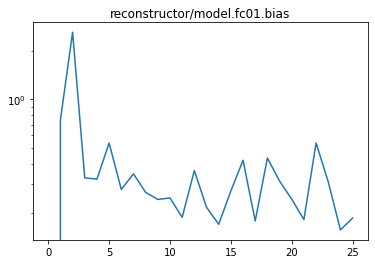

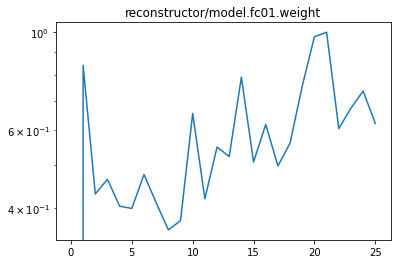

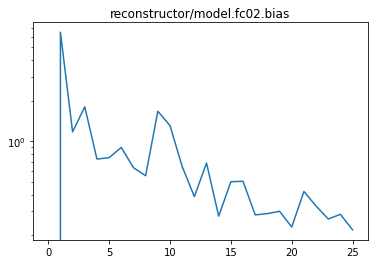

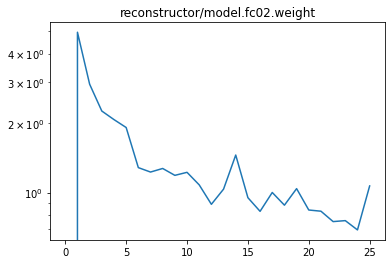

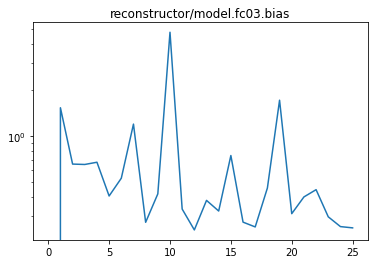

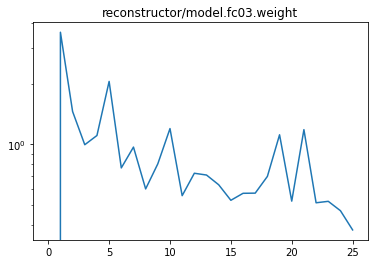

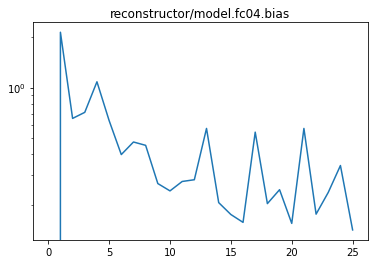

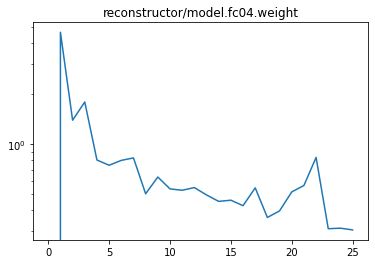

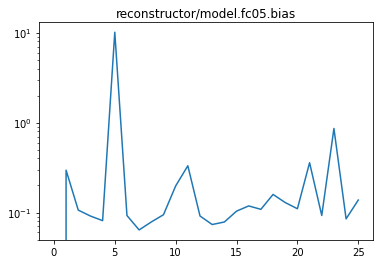

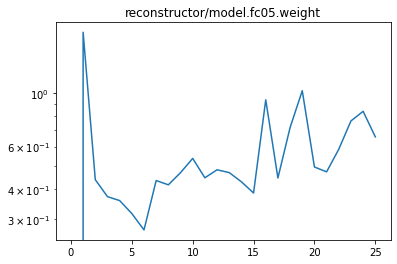

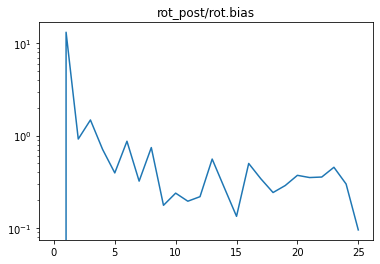

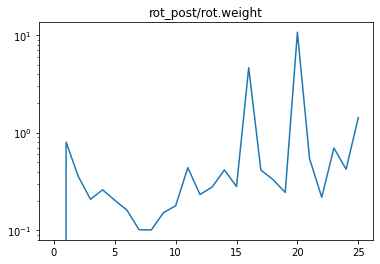

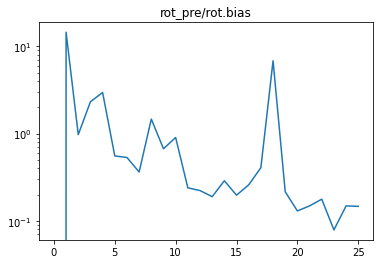

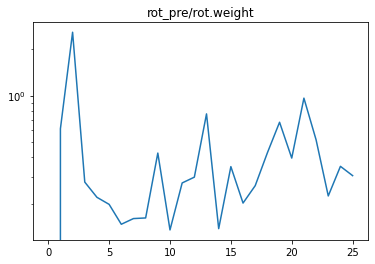

In [99]:
for key, vals in deltas_dct.items():
    plt.figure()
    plt.title(key)
    plt.plot(vals)
    plt.yscale('log')
    plt.show()

In [104]:
# grouping by trainable
deltas_dct_bytrainable = {}
for key, vals in deltas_dct.items():
    trainable, _ = key.split('/')
    if trainable not in deltas_dct_bytrainable:
        deltas_dct_bytrainable[trainable] = np.zeros(len(vals))
    deltas_dct_bytrainable[trainable] += vals

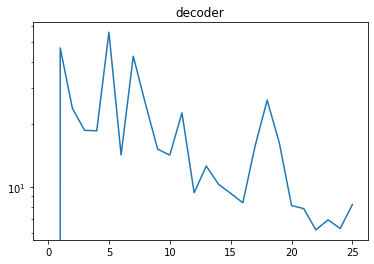

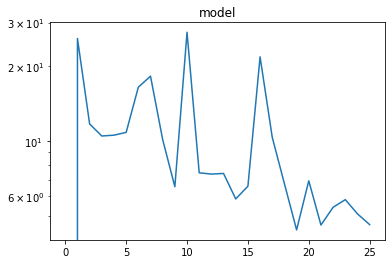

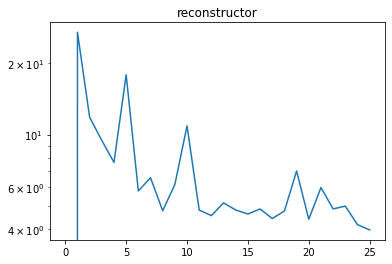

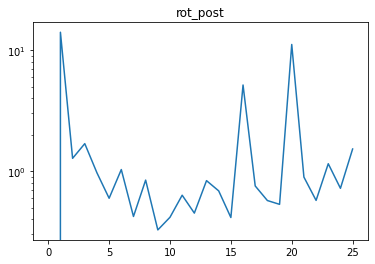

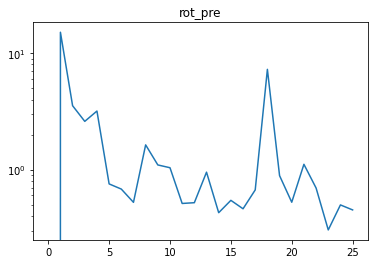

In [106]:
for key, vals in deltas_dct_bytrainable.items():
    plt.figure()
    plt.title(key)
    plt.plot(vals)
    plt.yscale('log')
    plt.show()

In [114]:
import gin

In [115]:
gin.clear_config()

In [116]:
ckpt = '/home/sergei/ray_results/rl_const_sparsity_obs_space_env_sm5_with_lagrange_dual_sparsity/main_fcn_a585f_00000_0_2021-03-24_17-47-40/checkpoint_473/checkpoint'
l = CPU_Unpickler(open(ckpt, 'rb')).load()

2021-03-26 03:50:00,393	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name f5140a52-8ddd-11eb-81af-90e2baa15164
Make environment SparseMatrix-v0 None {}
(pid=20689) Make environment SparseMatrix-v0 None {}
(pid=20668) Make environment SparseMatrix-v0 None {}


(pid=20672) Make environment SparseMatrix-v0 None {}


ERROR:root:Cannot collect data Use collect_and_get_context



[False, False, False]
[20, 128, 128, 1] 5
LSD (OrderedDict([('tensor', tensor([0.0000, 2.8257, 2.8257, 2.7575, 0.0000, 5.6516, 5.6516, 4.5280, 0.0000,
        4.2549, 4.2549, 4.5772, 0.0000])), ('initialized', [False, True, True, True, False, True, True, True, False, True, True, True, False])]),) {'strict': False}


In [117]:
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices, plot_model

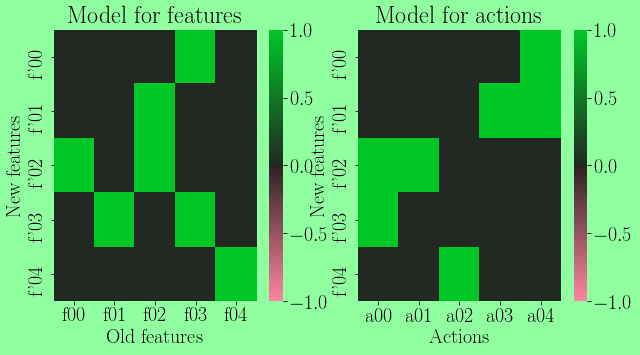

In [118]:

fig = plot_model(l.model)
fig.savefig('sm5_learned_graph_matrix.pdf', bbox_inches='tight')



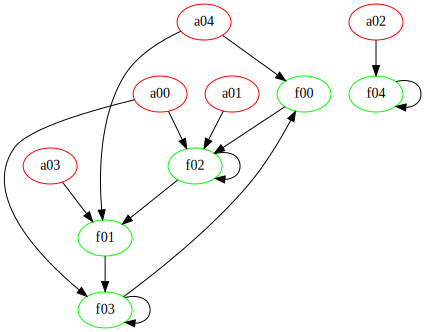

In [120]:
g = graph_for_matrices(l.model)[0]
g.view()
g

In [122]:
gin.clear_config()
ckpt = '/home/sergei/ray_results/rl_const_sparsity_obs_space_env_gw_with_lagrange_dual_sparsity/main_fcn_8953a_00000_0_2021-03-24_11-56-07/checkpoint_5240/checkpoint'
l = CPU_Unpickler(open(ckpt, 'rb')).load()

2021-03-26 03:56:53,228	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name eb25bd96-8dde-11eb-81af-90e2baa15164
Make environment GridWorldNavigation-v0 None {}
(pid=20717) Make environment GridWorldNavigation-v0 None {}


(pid=20723) Make environment GridWorldNavigation-v0 None {}
(pid=20699) Make environment GridWorldNavigation-v0 None {}


 [0.0405104  0.0395604  0.03862039 0.0402504  0.04133041]
 [0.04045041 0.0398604  0.03901039 0.03941039 0.0402204 ]
 [0.0399804  0.0395404  0.0406504  0.0400604  0.0401804 ]
 [0.03877039 0.03821038 0.04058041 0.0396604  0.0401604 ]] [[0.19541997 0.1919818  0.19464827 0.19939142 0.2048251 ]
 [0.1972031  0.19482785 0.19263226 0.1966402  0.19905077]
 [0.19706678 0.19576691 0.19352035 0.19448897 0.19656931]
 [0.19602829 0.19478303 0.19758244 0.19619861 0.1964576 ]
 [0.19298767 0.19171627 0.19734786 0.1950628  0.19641611]]


ERROR:root:Cannot collect data Use collect_and_get_context



[False, False]
[14, 64, 1] 3
[False]
[25, 1] 2
[False, False, False]
[3, 64, 32, 1] 25
LSD (OrderedDict([('tensor', tensor([-10.0008,   2.3750,   3.4288,   2.3080,   0.0000,   6.0659,   7.0000,
          3.6273, -10.0008,  -0.5070,  -0.9028,  -2.9084,   0.0000])), ('initialized', [False, True, True, True, False, True, True, True, False, True, True, True, False])]),) {'strict': False}


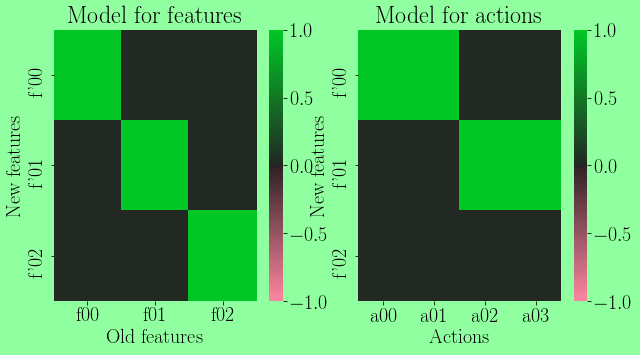

In [123]:

fig = plot_model(l.model)
fig.savefig('gw_learned_graph_matrix.pdf', bbox_inches='tight')



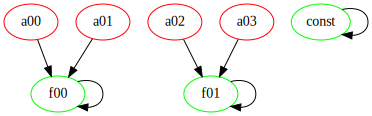

In [125]:
g = graph_for_matrices(l.model, last_is_constant=True)[0]
g.view()
g

In [127]:
ckpt = '/home/sergei/ray_results/rl_const_sparsity_obs_space_5x5_onlycoord_obs_env_kc_5x5_onlycoord_obs_with_lagrange_dual_sparsity/main_fcn_2f40c_00000_0_2021-03-25_22-00-52/checkpoint_40000/checkpoint'
gin.clear_config()
l = CPU_Unpickler(open(ckpt, 'rb')).load()

2021-03-26 04:07:02,151	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 5617d066-8de0-11eb-81af-90e2baa15164
Make environment KeyChest-v0 None {}
(pid=20666) Make environment KeyChest-v0 None {}
(pid=20659) Make environment KeyChest-v0 None {}
(pid=20676) Make environment KeyChest-v0 None {}
(pid=20651) Make environment KeyChest-v0 None {}
(pid=20646) Make environment KeyChest-v0 None {}


 0.55554557 0.         0.44443443 0.         0.33332333 0.
 0.22221223 0.         0.11110111 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.04202042 0.         0.04241043
 0.         0.0401204  0.         0.0398104  0.         0.04088041
 0.         0.         0.         0.         0.         0.0399104
 0.         0.0402404  0.         0.0405704  0.         0.03933039
 0.         0.03924039 0.         0.         0.         0.
 0.         0.04076041 0.         0.03957039 0.         0.0401804
 0.         0.03838038 0.         0.03801038 0.         0.
 0.         0.         0.         0.0402604  0.         0.0398504
 0.         0.0403204  0.         0.0399504  0.         0.03896039
 0.         0.         0.         0.         0.         0.0401

ERROR:root:Cannot collect data Use collect_and_get_context



[False, False, False]
[18, 1024, 1024, 1] 5
[False]
[126, 1] 4
[False, False, False]
[5, 256, 128, 1] 126


LSD (OrderedDict([('tensor', tensor([-1.0001e+01,  2.9824e+00, -1.0000e+01, -5.2120e-03,  0.0000e+00,
         6.1494e+00,  6.0615e+00,  3.9823e+00, -1.0001e+01, -1.0001e+01,
        -1.0001e+01, -3.4016e+00, -1.0001e+01,  0.0000e+00])), ('initialized', [False, True, True, True, False, True, True, True, False, True, True, True, False, False])]),) {'strict': False}


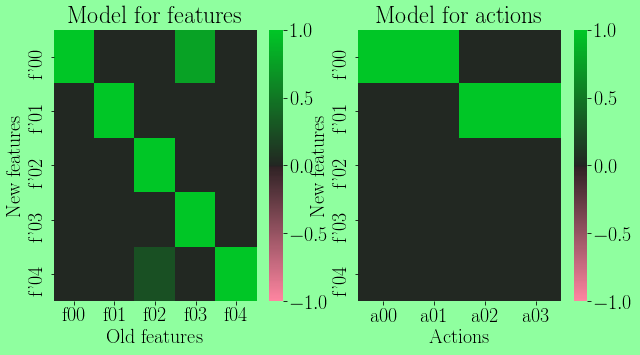

In [128]:

fig = plot_model(l.model)
fig.savefig('kc_with_h_learned_graph_matrix.pdf', bbox_inches='tight')



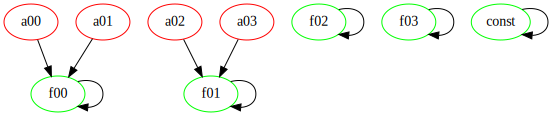

In [133]:
g = graph_for_matrices(l.model, last_is_constant=True, threshold_f=0.9)[0]
g.view()
g

In [131]:
graph_for_matrices

<function sparse_causal_model_learner_rl.visual.learner_visual.graph_for_matrices(model, threshold_act=0.2, threshold_f=0.2, do_write=True, additional_features=None, last_is_constant=False, feature_names=None, engine='dot')>